In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
import seaduck as sd
import cartopy.crs as ccrs

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ds = xr.open_zarr('/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/bgc_tutorial.zarr')

In [5]:
ds['utrans'] = ds['UVELMASS']*ds['drF']*ds['dyG']
ds['vtrans'] = ds['VVELMASS']*ds['drF']*ds['dxG']
ds['wtrans'] = ds['WVELMASS']*ds['rA']

In [6]:
tub = sd.OceData(ds)

In [7]:
ds

<xarray.Dataset>
Dimensions:        (time: 3000, Zl: 15, Y: 64, X: 128, Z: 15, Xp1: 129,
                    Yp1: 65, time_outer: 3001, Zp1: 16)
Coordinates:
  * X              (X) float64 1.406 4.219 7.031 9.844 ... 353.0 355.8 358.6
  * Xp1            (Xp1) float64 0.0 2.812 5.625 8.438 ... 354.4 357.2 360.0
  * Y              (Y) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * Yp1            (Yp1) float64 -90.0 -87.19 -84.38 -81.56 ... 84.38 87.19 90.0
  * Z              (Z) float64 -25.0 -85.0 -170.0 ... -4.19e+03 -4.855e+03
  * Zl             (Zl) float64 0.0 -50.0 -120.0 ... -3.87e+03 -4.51e+03
  * Zp1            (Zp1) float64 0.0 -50.0 -120.0 ... -4.51e+03 -5.2e+03
  * time           (time) float64 2.239e+11 2.239e+11 ... 2.252e+11 2.252e+11
  * time_outer     (time_outer) float64 2.239e+11 2.239e+11 ... 2.252e+11
Data variables: (12/65)
    ADVrTr01       (time, Zl, Y, X) float32 dask.array<chunksize=(20, 15, 64, 128), meta=np.ndarray>
    ADVrTr03       (time, Zl, Y, X) float32 dask.array<chunksize=(20, 15, 64, 128), meta=np.ndarray>
    ADVxTr01       (time, Z, Y, Xp1) float32 dask.array<chunksize=(20, 15, 64, 129), meta=np.ndarray>
    ADVxTr03       (time, Z, Y, Xp1) float32 dask.array<chunksize=(20, 15, 64, 129), meta=np.ndarray>
    ADVyTr01       (time, Z, Yp1, X) float32 dask.array<chunksize=(20, 15, 65, 128), meta=np.ndarray>
    ADVyTr03       (time, Z, Yp1, X) float32 dask.array<chunksize=(20, 15, 65, 128), meta=np.ndarray>
    ...             ...
    rAs            (Yp1, X) float64 dask.array<chunksize=(65, 128), meta=np.ndarray>
    rAw            (Y, Xp1) float64 dask.array<chunksize=(64, 129), meta=np.ndarray>
    rAz            (Yp1, Xp1) float64 dask.array<chunksize=(65, 129), meta=np.ndarray>
    utrans         (time, Z, Y, Xp1) float64 dask.array<chunksize=(20, 15, 64, 129), meta=np.ndarray>
    vtrans         (time, Z, Yp1, X) float64 dask.array<chunksize=(20, 15, 65, 128), meta=np.ndarray>
    wtrans         (time, Zl, Y, X) float64 dask.array<chunksize=(20, 15, 64, 128), meta=np.ndarray>
Attributes: (12/22)
    MITgcm_URL:      http://mitgcm.org
    MITgcm_mnc_ver:  0.9
    MITgcm_tag_id:   
    MITgcm_version:  checkpoint68v
    Nr:              15
    Nx:              128
    ...              ...
    nSx:             1
    nSy:             2
    sNx:             64
    sNy:             32
    the_run_name:    Tutorial Biogeo
    tile_number:     1

In [8]:
wmean = ds.WVELMASS.mean(dim = 'time')

In [9]:
wmean = wmean.persist()

In [10]:
wtemp = np.zeros((16,64,128))
wtemp[:15] = wmean.data
vert = (wtemp[1:]+wtemp[:-1])/2
vert = xr.DataArray(vert,dims = ('Z','Y','X'))

In [11]:
ds.S

<xarray.DataArray 'S' (time_outer: 3001, Z: 15, Y: 64, X: 128)>
dask.array<open_dataset-S, shape=(3001, 15, 64, 128), dtype=float32, chunksize=(20, 15, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * X           (X) float64 1.406 4.219 7.031 9.844 ... 350.2 353.0 355.8 358.6
  * Y           (Y) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * Z           (Z) float64 -25.0 -85.0 -170.0 ... -4.19e+03 -4.855e+03
  * time_outer  (time_outer) float64 2.239e+11 2.239e+11 ... 2.252e+11 2.252e+11
Attributes:
    long_name:  salinity

In [12]:
def densjmd95(s, t, p):
    """
    Density of Sea Water using Jackett and McDougall 1995 (JAOT 12)
    polynomial (modified UNESCO polynomial) [JaMc95]_.
    jmd95.py:
    `<http://mitgcm.org/\
    download/daily_snapshot/MITgcm/utils/python/MITgcmutils/MITgcmutils/jmd95.py>`_

    Parameters
    ----------
    s: xarray.DatArray, array-like
        salinity    [psu (PSS-78)]
    t: xarray.DatArray, array-like
        potential temperature [degree C (IPTS-68)]
    p: xarray.DatArray, array-like
        pressure [dbar]
        (p may have dims 1x1, mx1, 1xn or mxn for S(mxn))

    Returns
    -------
    rho: xarray.DatArray, array-like
        density  [kg/m^3]

    References
    ----------
    .. [JaMc95]
        Jackett, D.R. and T.J. Mcdougall, 1995:\
        Minimal Adjustment of Hydrographic Profiles\
        to Achieve Static Stability.\
        J. Atmos. Oceanic Technol., 12, 381–389,\
        https://doi.org/10.1175/1520-0426(1995)012<0381:MAOHPT>2.0.CO;2
    """

    # make sure arguments are floating point
    for var in [s, t, p]:
        if isinstance(var, xr.DataArray):
            var = var.astype("float")
        else:
            var = np.asfarray(var)

    # coefficients nonlinear equation of state in pressure coordinates for
    # 1. density of fresh water at p = 0
    eosJMDCFw = [
        999.842594,
        6.793952e-02,
        -9.095290e-03,
        1.001685e-04,
        -1.120083e-06,
        6.536332e-09,
    ]

    # 2. density of sea water at p = 0
    eosJMDCSw = [
        8.244930e-01,
        -4.089900e-03,
        7.643800e-05,
        -8.246700e-07,
        5.387500e-09,
        -5.724660e-03,
        1.022700e-04,
        -1.654600e-06,
        4.831400e-04,
    ]

    # coefficients in pressure coordinates for
    # 3. secant bulk modulus K of fresh water at p = 0
    eosJMDCKFw = [1.965933e04, 1.444304e02, -1.706103e00, 9.648704e-03, -4.190253e-05]

    # 4. secant bulk modulus K of sea water at p = 0
    eosJMDCKSw = [
        5.284855e01,
        -3.101089e-01,
        6.283263e-03,
        -5.084188e-05,
        3.886640e-01,
        9.085835e-03,
        -4.619924e-04,
    ]

    # 5. secant bulk modulus K of sea water at p
    eosJMDCKP = [
        3.186519e00,
        2.212276e-02,
        -2.984642e-04,
        1.956415e-06,
        6.704388e-03,
        -1.847318e-04,
        2.059331e-07,
        1.480266e-04,
        2.102898e-04,
        -1.202016e-05,
        1.394680e-07,
        -2.040237e-06,
        6.128773e-08,
        6.207323e-10,
    ]

    # convert pressure to bar
    p = 0.1 * p
    p2 = p * p
    t2 = t * t
    t3 = t2 * t
    t4 = t3 * t
    s3o2 = s * np.sqrt(s)

    # density of freshwater at the surface
    rho = (
        eosJMDCFw[0]
        + eosJMDCFw[1] * t
        + eosJMDCFw[2] * t2
        + eosJMDCFw[3] * t3
        + eosJMDCFw[4] * t4
        + eosJMDCFw[5] * t4 * t
    )

    # density of sea water at the surface
    rho = (
        rho
        + s
        * (
            eosJMDCSw[0]
            + eosJMDCSw[1] * t
            + eosJMDCSw[2] * t2
            + eosJMDCSw[3] * t3
            + eosJMDCSw[4] * t4
        )
        + s3o2 * (eosJMDCSw[5] + eosJMDCSw[6] * t + eosJMDCSw[7] * t2)
        + eosJMDCSw[8] * s * s
    )

    # secant bulk modulus of fresh water at the surface
    bulkmod = (
        eosJMDCKFw[0]
        + eosJMDCKFw[1] * t
        + eosJMDCKFw[2] * t2
        + eosJMDCKFw[3] * t3
        + eosJMDCKFw[4] * t4
    )

    # secant bulk modulus of sea water at the surface
    bulkmod = (
        bulkmod
        + s
        * (eosJMDCKSw[0] + eosJMDCKSw[1] * t + eosJMDCKSw[2] * t2 + eosJMDCKSw[3] * t3)
        + s3o2 * (eosJMDCKSw[4] + eosJMDCKSw[5] * t + eosJMDCKSw[6] * t2)
    )

    # secant bulk modulus of sea water at pressure p
    bulkmod = (
        bulkmod
        + p * (eosJMDCKP[0] + eosJMDCKP[1] * t + eosJMDCKP[2] * t2 + eosJMDCKP[3] * t3)
        + p * s * (eosJMDCKP[4] + eosJMDCKP[5] * t + eosJMDCKP[6] * t2)
        + p * s3o2 * eosJMDCKP[7]
        + p2 * (eosJMDCKP[8] + eosJMDCKP[9] * t + eosJMDCKP[10] * t2)
        + p2 * s * (eosJMDCKP[11] + eosJMDCKP[12] * t + eosJMDCKP[13] * t2)
    )
    rho = rho / (1.0 - p / bulkmod)

    return rho


In [13]:
rho = densjmd95(ds.S, ds.Temp, 0)-1000

In [14]:
rhom = rho.mean(dim = 'time_outer').persist()

In [15]:
rhom = np.array(rhom)

In [16]:
rhom[ds.S[0]==0] = np.nan

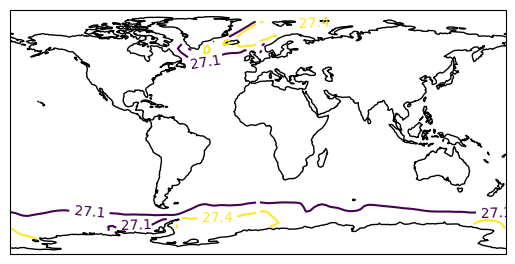

In [17]:
ax = plt.axes(projection = ccrs.PlateCarree())
ct = ax.contour(ds.XC,ds.YC,rhom[0],levels = [27.1,27.4])
plt.clabel(ct)
ax.coastlines()

-670.0


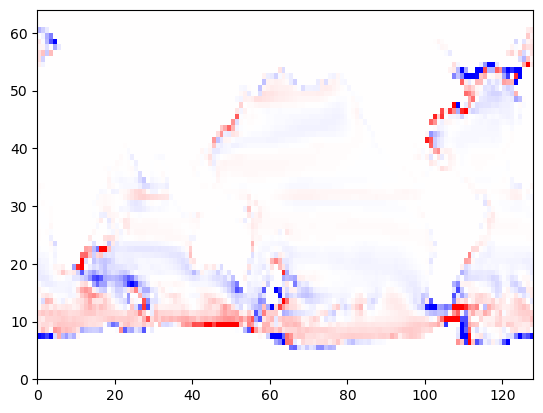

In [18]:
vmax = 1e-5
iz = 5
print(float(ds.Z[iz]))
plt.pcolormesh(vert[iz],vmax = vmax,vmin = -vmax, cmap = 'bwr')

In [19]:
ds.Zl

<xarray.DataArray 'Zl' (Zl: 15)>
array([    0.,   -50.,  -120.,  -220.,  -360.,  -550.,  -790., -1080., -1420.,
       -1810., -2250., -2740., -3280., -3870., -4510.])
Coordinates:
  * Zl       (Zl) float64 0.0 -50.0 -120.0 ... -3.28e+03 -3.87e+03 -4.51e+03
Attributes:
    long_name:  vertical coordinate of upper cell interface
    positive:   up
    units:      meters

In [20]:
ymask = np.logical_and(ds.Y>-90,ds.Y<-45)
zmask = np.logical_and(ds.Z>-1080,ds.Z<0)
smask = np.logical_and(vert>0,True)#np.logical_or(rhom<27.1,rhom>27.5))
# smask = np.logical_and(vert>0,True)
mask = np.logical_and(np.logical_and(smask,ymask),zmask)

In [21]:
# ymask = np.logical_and(ds.Y>-90,ds.Y<-45)
# zmask = np.logical_and(ds.Z>-550,ds.Z<0)
# smask = np.logical_and(vert>0,True)#np.logical_or(rhom<27.1,rhom>27.5))
# # smask = np.logical_and(vert>0,True)
# mask1 = np.logical_and(np.logical_and(smask,ymask),zmask)

In [23]:
# np.logical_or(~mask1,mask).all()

In [24]:
tf = float(ds.time[0])
t0 = float(ds.time[-1])

In [25]:
pt = sd.Particle(
    bool_array=mask, num=10000, random_seed=712,
    t = tf,
    data = tub, free_surface = 'kick_back',
    save_raw = True,
    uname = 'utrans',vname = 'vtrans',wname = 'wtrans',
    transport = True
)

In [26]:
# pt1 = sd.Particle(
#     bool_array=mask1, num=10000, random_seed=404,
#     t = tf,
#     data = tub, free_surface = 'kick_back',
#     save_raw = True,
#     uname = 'utrans',vname = 'vtrans',wname = 'wtrans',
#     transport = True
# )

In [28]:
# np.logical_and(pt1.lat<-65,pt1.dep>-50).any()

In [29]:
np.logical_and(pt.lat<-65,pt.dep>-50).any()

False

In [31]:
# ax = plt.axes(projection = ccrs.PlateCarree())
# ax.plot(sd.utils.to_180(pt1.lon),pt1.lat,'o',markersize = 0.1)
# ax.coastlines()
# ax.set_ylim(-90,90)

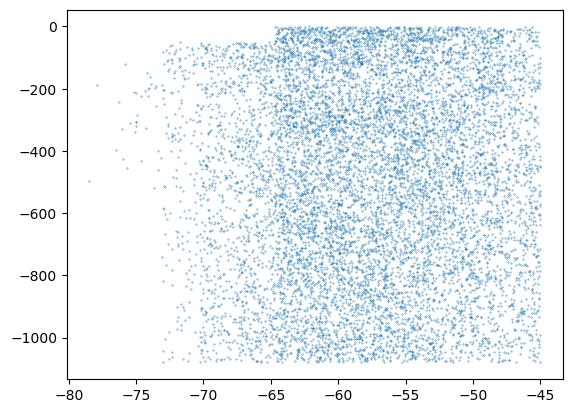

In [32]:
plt.plot(pt.lat,pt.dep,'o',markersize = 0.3)

In [33]:
tub['maskC'] = tub['HFacC']
tub['time_midp'] = tub['time_outer'][1:-1]

In [34]:
output_path = '/export/scratch/wjiang33/dic/'

In [35]:
pt.to_list_of_time(normal_stops = np.linspace(tf,t0,2)[1:],dump_filename = output_path+'forward',store_kwarg = {'preserve_checks':True})

9066-09-04T12:00:00
9066-09-09T12:00:00
9066-09-14T12:00:00
9066-09-19T12:00:00
9066-09-24T12:00:00
9066-09-29T12:00:00
9066-10-04T12:00:00
9066-10-09T12:00:00
9066-10-14T12:00:00
9066-10-19T12:00:00
9066-10-24T12:00:00
9066-10-29T12:00:00
9066-11-03T12:00:00
9066-11-08T12:00:00
9066-11-13T12:00:00
9066-11-18T12:00:00
9066-11-23T12:00:00
9066-11-28T12:00:00
9066-12-03T12:00:00
9066-12-08T12:00:00
9066-12-13T12:00:00
9066-12-18T12:00:00
9066-12-23T12:00:00
9066-12-28T12:00:00
9067-01-02T12:00:00
9067-01-07T12:00:00
9067-01-12T12:00:00
9067-01-17T12:00:00
9067-01-22T12:00:00
9067-01-27T12:00:00
9067-02-01T12:00:00
9067-02-06T12:00:00
9067-02-11T12:00:00
9067-02-16T12:00:00
9067-02-21T12:00:00
9067-02-26T12:00:00
9067-03-03T12:00:00
9067-03-08T12:00:00
9067-03-13T12:00:00
9067-03-18T12:00:00
9067-03-23T12:00:00
9067-03-28T12:00:00
9067-04-02T12:00:00
9067-04-07T12:00:00
9067-04-12T12:00:00
9067-04-17T12:00:00
9067-04-22T12:00:00
9067-04-27T12:00:00
9067-05-02T12:00:00
9067-05-07T12:00:00


In [ ]:
1

In [ ]:
1

In [ ]:
1

In [ ]:
1

In [ ]:
pt.it[0]